In [7]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import pickle
from time import time

from consav import linear_interp

import LimitedCommitmentModel as lcm

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = True
do_compile = True
do_egm = True
threads = 24

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [8]:
# compile c++ files
if do_cpp & do_compile:
    model = lcm.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)
    model.cpp.delink()

# Solve and simulate from alternative models

In [9]:
# settings for models to solve
T = 20
sigma = 0.1
num_love = 21
num_A = 50
num_A_pd = 50

uniform_mat = np.ones((num_A,num_A))/num_A

settings = { 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':sigma,
       'T':T,'do_cpp':do_cpp,
       'threads':threads, 
       'interp_power':False,
       'num_love': num_love, 
       'do_egm':True, 
       'num_A': num_A_pd, 
       'num_A_pd':num_A_pd,
       'num_Ctot':50,
       'simT':T,
       'simN': 500,
       }


solution_specs = {'solution': {'latexname':'Solution', 'par':{**settings, 'do_egm':True, 'num_A': 500, 'num_A_pd': 500, 'num_Ctot':500, 'num_power':101, 'num_love':201}}}

num_margu = 15

# specs = {
#     'model 1':{'latexname':'VFI', 'par':{**settings, 'use_external_solution':True, 'do_egm':False}},
#     'model 2':{'latexname':f'iEGM c{num_margu} linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu}},
#     'model 3':{'latexname':'iEGM c100 linear', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100}},
#     'model 4':{'latexname':f'iEGM c{num_margu}, linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':num_margu, 'interp_inverse': True}},
#     'model 5':{'latexname':'iEGM c100 linear inverse', 'par':{**settings, 'use_external_solution':True, 'num_marg_u':100, 'interp_inverse': True}},
#     }

specs = {'model 1':{'latexname':'VFI', 'par':{**settings, 'do_egm':False}},
         'model 2':{'latexname':'iEGM, linear interp', 'par':{**settings, 'do_egm': True}},
         'model 3':{'latexname':'iEGM, linear inverse interp', 'par':{**settings, 'do_egm': True, 'interp_inverse': True}},
         'model 4':{'latexname':'EGM, numerical inverse', 'par':{**settings, 'do_egm': True, 'interp_method': "numerical"}},
         
}


In [10]:
# solve/load solution Marginal values
do_load = True
do_save = False
do_solve = False

if do_solve:
    model_solution = lcm.HouseholdModelClass(par=solution_specs['solution']['par'])

    print('Linking to c++')
    model_solution.link_to_cpp(force_compile=False)

    print('Solving solution model')
    %time model_solution.solve()

    EmargV_start_as_couple_true = model_solution.sol.EmargV_start_as_couple
    EmargVw_start_as_single_true = model_solution.sol.EmargVw_start_as_single
    EmargVm_start_as_single_true = model_solution.sol.EmargVm_start_as_single
    grid_A_true = model_solution.par.grid_A
    grid_power_true = model_solution.par.grid_power
    grid_love_true = model_solution.par.grid_love

    margV_list = [EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true]

    ## saveobject in pickle
    if do_save:
        with open('output/solution_margV.pkl', 'wb') as f:
            pickle.dump(margV_list, f)
        print('Saved solution margVs')

if do_load:
    with open('output/solution_margV.pkl', 'rb') as f:
        EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true = pickle.load(f)
    print('Loaded solution margVs')


Loaded solution margVs


In [11]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'\nsolving {spec["latexname"]}...')
    
    # setup model
    models[name] = lcm.HouseholdModelClass(name=name,par=spec['par'])
    models[name].par.seed = 0
    models[name].allocate()

    if models[name].par.use_external_solution:
        print("Set external solution for computing Euler Errors")
        models[name].set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

        
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec

    # # solve
    %time models[name].solve()

    # # simulate
    # print(f'Simulating {spec["latexname"]}...')
    # %time models[name].simulate()
    # print(f'Mean log10 euler error: {models[name].sim.mean_log10_euler}')




solving VFI...
CPU times: total: 58.2 s
Wall time: 3.65 s

solving iEGM, linear interp...
CPU times: total: 3.69 s
Wall time: 237 ms

solving iEGM, linear inverse interp...
CPU times: total: 3.16 s
Wall time: 222 ms

solving EGM, numerical inverse...
CPU times: total: 4min 52s
Wall time: 26 s


In [12]:
m1 = models['model 1']
m2 = models['model 2']
m3 = models['model 3']
m4 = models['model 4']

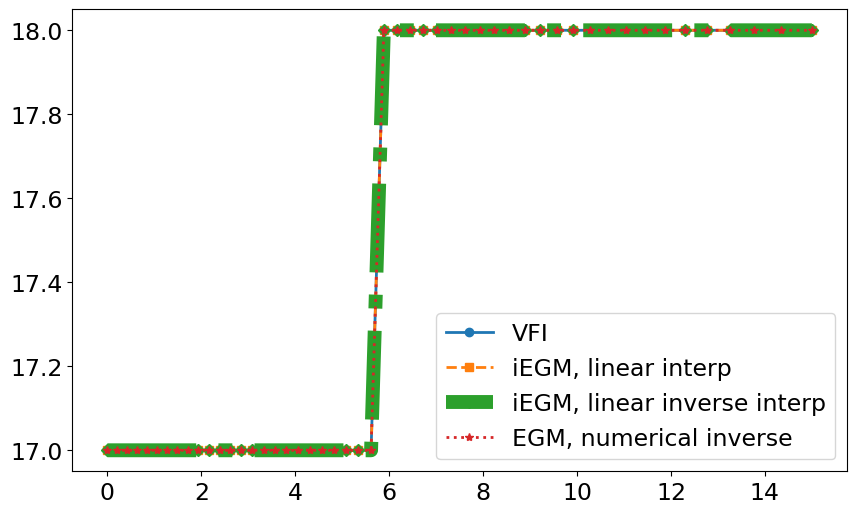

In [93]:
# plot model solutions
grid = 'grid_A'
var = 'power_idx'
#var = 'C_tot_start_as_couple'

t = 15
iP = 18
iL = 10
iA = 21

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    lw = linewidth*5 if name == 'model 3' else linewidth

    ax.plot(getattr(par,grid), getattr(sol,var)[t,iP,iL], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=lw)
    i += 1
ax.legend()


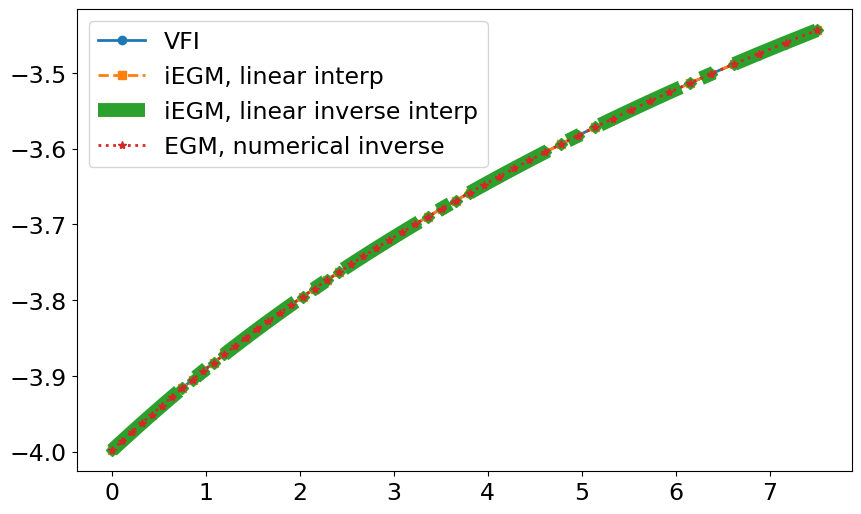

In [92]:
# plot model solutions
grid = 'grid_Aw'
var = 'EVw_start_as_single'

t = 12

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
i = 0
for name, model in models.items():
    
    par = model.par
    sol = model.sol

    lw = linewidth*5 if name == 'model 3' else linewidth

    ax.plot(getattr(par,grid), getattr(sol,var)[t], label=model.spec['latexname'], linestyle=linestyles[i], marker=markers[i], linewidth=lw)
    i += 1
ax.legend()

In [91]:
# Re-compile and solve
for model in models.values():
    model.cpp.delink()

recompile = True
for name in models.keys():
    models[name].link_to_cpp(force_compile=recompile)

    print(f'\nsolving {name}...')
    models[name].allocate()
    %time models[name].solve()
    

    recompile = False



solving model 1...
CPU times: total: 49.2 s
Wall time: 3.35 s

solving model 2...
CPU times: total: 2.58 s
Wall time: 151 ms

solving model 3...
CPU times: total: 2.83 s
Wall time: 149 ms

solving model 4...
CPU times: total: 4min 52s
Wall time: 25.3 s


## Monte Carlo runs

In [18]:
MC_num = 50 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM

specs = {'centered_gradient':True, 
       'p_meet': 0.1, 
       'div_A_share': 0.5, 
       'sigma_love':0.1,
       'T':20,
       'do_cpp':True,
       'threads':50,
       'simT':T,
       'simN': 1000,
       'use_external_solution':True,
       }

In [19]:
PRINT = True
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

In [22]:
# loop over Monte Carlo simulations
for i_mc in range(i_mc,MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    model = lcm.HouseholdModelClass(par=specs)

    model.par.seed = i_mc
    model.allocate()
    model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

    model.link_to_cpp(force_compile=False)

    # VFI
    model.par.do_egm = False
    
    # Timing
    t0 = time()
    model.solve()
    timing['vfi'][i_mc] = time() - t0

    # Euler error
    model.simulate()
    error['vfi'][i_mc] = model.sim.mean_log10_euler

    # iEGM
    model.par.do_egm = True
    for interp_inverse in (False,True):
        model.par.interp_inverse = interp_inverse
        method = f'iegm, linear inverse' if interp_inverse else 'iegm, linear'
        for i_c,num_C in enumerate(C_num_grid):
            model.par.num_marg_u = num_C

            model.allocate()
            model.set_true_EmargV(EmargV_start_as_couple_true, EmargVw_start_as_single_true, EmargVm_start_as_single_true, grid_A_true, grid_power_true, grid_love_true)

            # Timing
            t0 = time()
            model.solve()
            timing[method][num_C][i_mc] = time() - t0

            # Euler error
            model.simulate()
            error[method][num_C][i_mc] = model.sim.mean_log10_euler

# save MC objects
with open('output/MC_timing.pkl', 'wb') as f:
    pickle.dump(timing, f)
with open('output/MC_error.pkl', 'wb') as f:
    pickle.dump(error, f)

16/50 running...
17/50 running...
18/50 running...
19/50 running...
20/50 running...
21/50 running...
22/50 running...
23/50 running...
24/50 running...
25/50 running...
26/50 running...
27/50 running...
28/50 running...
29/50 running...
30/50 running...
31/50 running...
32/50 running...
33/50 running...
34/50 running...
35/50 running...
36/50 running...
37/50 running...
38/50 running...
39/50 running...
40/50 running...
41/50 running...
42/50 running...
43/50 running...
44/50 running...
45/50 running...
46/50 running...
47/50 running...
48/50 running...
49/50 running...
50/50 running...


In [31]:
print('Euler Error & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi',):
    error_now = np.mean(error[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {error_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        error_now = np.mean(error[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {error_now:2.3f} & {time_now:2.3f} ')

Euler Error & Timing (rel. to VFI)
vfi: -5.653 & 1.000 
iegm, linear: 
20 -3.719 & 0.098 
50 -4.683 & 0.098 
100 -5.327 & 0.098 
200 -5.518 & 0.099 
iegm, linear inverse: 
20 -4.000 & 0.098 
50 -5.553 & 0.098 
100 -5.548 & 0.098 
200 -5.394 & 0.099 
